In [1]:
import numpy as np 
import astropy.units as units
from astropy.time import Time 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import cloudpickle
import sys 
sys.path.append("helpers")
import data 
import xo_archive
import fit

from scipy.stats import norm 
from importlib import reload
import exoplanet as xo 
xo.utils.docs_setup()
import lightkurve as lk 

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.pymc3 import terms, GaussianProcess
import arviz as az
import corner

reload(xo_archive)

matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

In [2]:
def model_data_residuals(param_lists, lc):
    constant = 1

    orbits = {}
    for i in range(len(param_lists['pl_letter'])):
        orbits[param_lists['pl_letter'][i]] = xo.orbits.SimpleTransitOrbit(period=param_lists["pl_orbper"][i], 
                                                                           t0=(Time(param_lists["pl_tranmid"][i],format="jd").bkjd),
                                                                           b=param_lists['pl_imppar'][i], 
                                                                           duration=param_lists['pl_trandur'][i]/24,
                                                                           r_star=param_lists['st_rad'][i],
                                                                           ror=param_lists['pl_ratror'][i])
    t = lc.time.value
    u = [0.3, 0.2]

    light_curves = {}
    for i in range(len(param_lists['pl_letter'])):
        light_curves[param_lists['pl_letter'][i]] = (xo.LimbDarkLightCurve(*u).get_light_curve(orbit=orbits[param_lists['pl_letter'][i]], 
                                                                                               r=param_lists['st_rad'][i]*param_lists['pl_ratror'][i],
                                                                                               t=t).eval())
        
    dataset = np.array(lc.flux)
    model = sum(light_curves.values())
    model = model.flatten()
    difference = (dataset - model)
    
    diff_sorted = np.sort(difference)
    N = len(diff_sorted)
    p = np.arange(N)
    f = lambda x: np.interp(x, p, diff_sorted)
    one_sigma_pos = f((0.8413)*N)
    one_sigma_neg = f((1-0.8413)*N)
    std_calculated = (one_sigma_pos - one_sigma_neg)/2
    
    mean_tweaked = np.mean(difference[((np.median(difference) - std_calculated) < difference) & (difference < (np.median(difference) + std_calculated))])
    
    return model, difference, std_calculated, mean_tweaked
    

In [3]:
def remove_outliers(sigma, lc, difference, std_calculated, mean_tweaked):
        
    flags_sigma = ((mean_tweaked-(sigma*std_calculated)) > difference) | ((mean_tweaked+(sigma*std_calculated)) < difference)
        
    lc_clean = lc[~flags_sigma]
        
    lc_final = np.ma.filled(lc_clean, fill_value=np.nan).remove_nans()
        
    return lc_final, flags_sigma
    

In [4]:
def diagnostic_plots(lc, lc_final, model, difference, std_calculated, mean_tweaked, sigma):
    
    p = lc.scatter()
    plt.close()
    fig, ax = plt.subplots(figsize=(12,6))
    plt.plot(lc.time.value,lc.flux.value,color='k',marker='o',ls='',label='data')
    plt.plot(lc.time.value,difference,marker='o',ls='',color='green',label='difference')
    plt.plot(lc.time.value, model+1,color='orange',lw=3,label='model')
    plt.xlabel(p.get_xlabel())
    plt.ylabel(p.get_ylabel())
    plt.xlim(600,700)
    plt.ylim(0.998, 1.001)
    plt.legend(loc='lower left',fontsize=12)
    plt.show()
    
    fig, ax = plt.subplots()
    diff_sorted = np.sort(difference)
    norm_cdf = norm.cdf((diff_sorted - mean_tweaked)/std_calculated)
    N = len(diff_sorted)
    p = np.arange(N)
    plt.plot(p, diff_sorted,label='residuals cdf')
    plt.plot(norm_cdf*N, diff_sorted, label='gaussian cdf')
    plt.ylim(0.9995,1.0005)
    plt.axhline(mean_tweaked,color='k')
    plt.axhline(mean_tweaked-std_calculated,color='k')
    plt.axhline(mean_tweaked+std_calculated,color='k')
    plt.xlabel("frequency")
    plt.ylabel("flux")
    plt.legend(fontsize=12)
    plt.show()
    
    fig, ax = plt.subplots()
    h, bins = np.histogram(difference, bins=1000)
    plt.hist(difference, bins=bins, density=True)
    plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black',label='gaussian')
    plt.axvline(mean_tweaked-(sigma*std_calculated),color='red')
    plt.axvline(mean_tweaked+(sigma*std_calculated),color='red',label="{0} sigma".format(sigma))
    plt.ylim(1e-6,1e4)
    plt.xlim(0.999,1.001)
    plt.yscale('log')
    plt.xlabel("difference")
    plt.ylabel("probability")
    plt.legend(fontsize=12)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.scatter(lc.time.value, lc.flux.value,label='difference')
    plt.scatter(lc.time.value[flags_nsigma], lc.flux.value[flags_nsigma],label='outliers')
    plt.plot(lc.time.value, model+1,color='orange',label='model')
    plt.ylim(0.997, 1.003)
    plt.xlim(600,700)
    plt.xlabel("time")
    plt.ylabel("flux")
    plt.legend(fontsize=12)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.scatter(difference[flags_nsigma],model[flags_nsigma],label='outliers',color='k')
    #plt.xlim(0.999,1.0005)
    plt.xlabel("difference")
    plt.ylabel("model")
    plt.legend(fontsize=12)
    plt.show()
    
    for i in range(len(planet_parameters)):
        ax = lc_final.fold(period=planet_parameters[i]["pl_orbper"],
                 epoch_time=Time(planet_parameters[i]["pl_tranmid"],
                                 format="jd").bkjd).scatter(label=planet_parameters[i]["pl_name"], alpha=0.05)
        plt.show()

In [5]:
planet_parameters = xo_archive.get_exoplanet_parameters("Kepler-109 ", which="composite")
param_lists = xo_archive.transpose_parameters(planet_parameters)

search_results = lk.search_lightcurve("Kepler-109", mission="Kepler", exptime=1800)
lcc = search_results.download_all()
lc = lcc.stitch().remove_nans()

(0.995, 1.005)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Sans


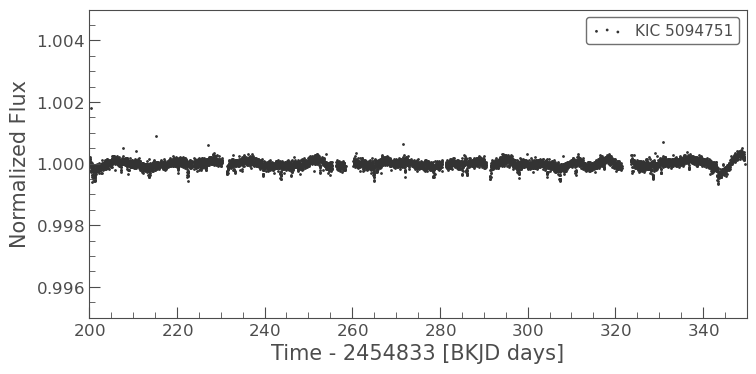

In [6]:
lc.scatter()
plt.xlim(200,350)
plt.ylim(0.995,1.005)

In [7]:
param_lists

{'pl_name': ['Kepler-109 b', 'Kepler-109 c'],
 'pl_letter': ['b', 'c'],
 'pl_orbper': [6.4816307, 21.22265],
 'pl_orbincl': [87.06, 89.63],
 'pl_orbeccen': [0.11, 0.098],
 'pl_trandep': [0.03015, 0.03599],
 'pl_tranmid': [2454955.97791, 2454970.5722],
 'pl_trandur': [3.649, 6.4913],
 'pl_ratror': [0.01686, 0.01734],
 'pl_imppar': [0.58, 0.16],
 'st_rad': [1.39, 1.39],
 'st_mass': [1.09, 1.09],
 'st_dens': [0.65, 0.65],
 'gaia_id': ['Gaia DR2 2101175933393051008', 'Gaia DR2 2101175933393051008'],
 'pl_rade': [2.49, 2.65],
 'berger_dens': [0.5557129614951429, 0.5557129614951429]}

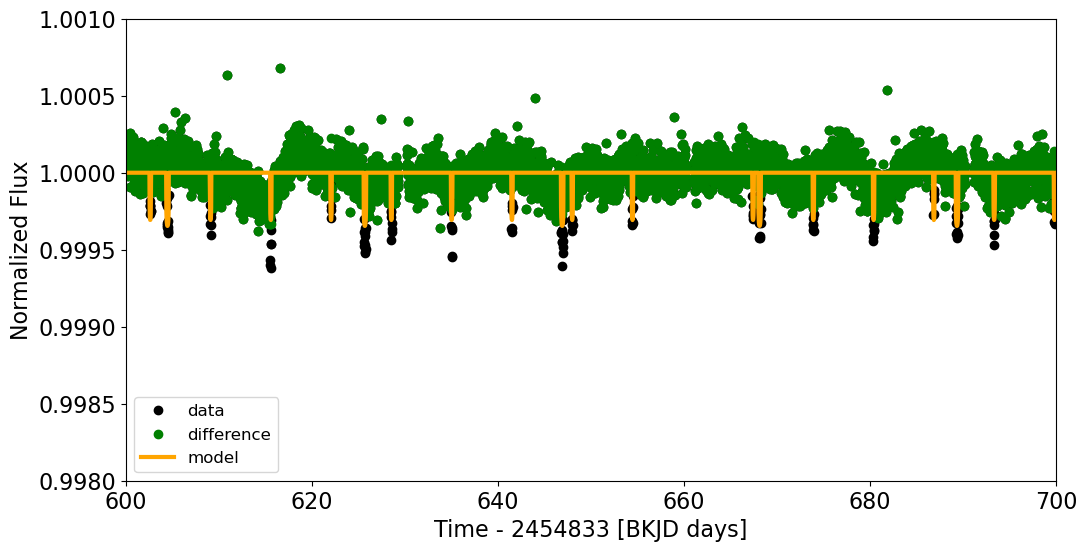

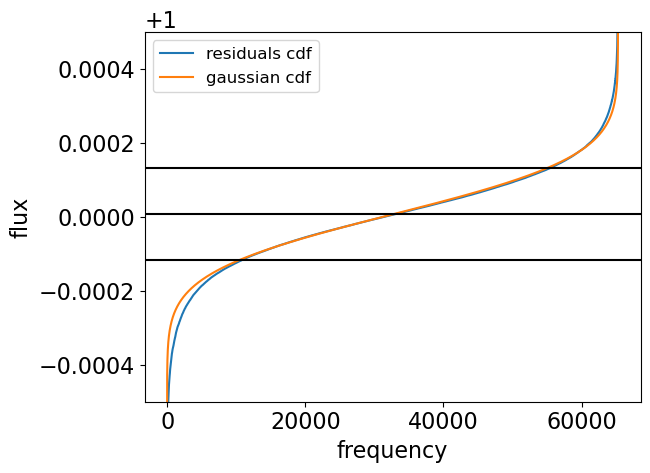

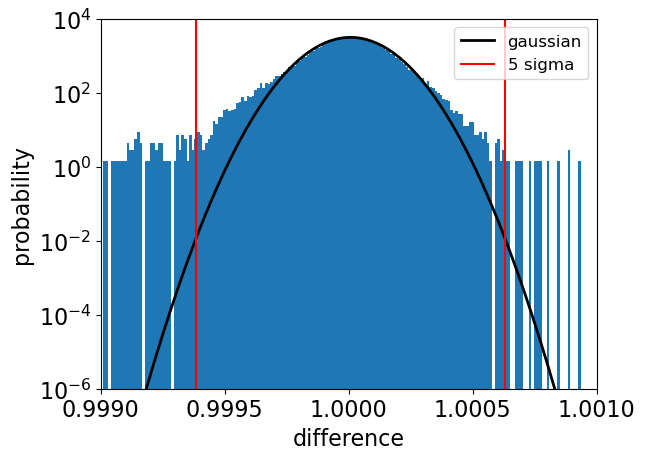

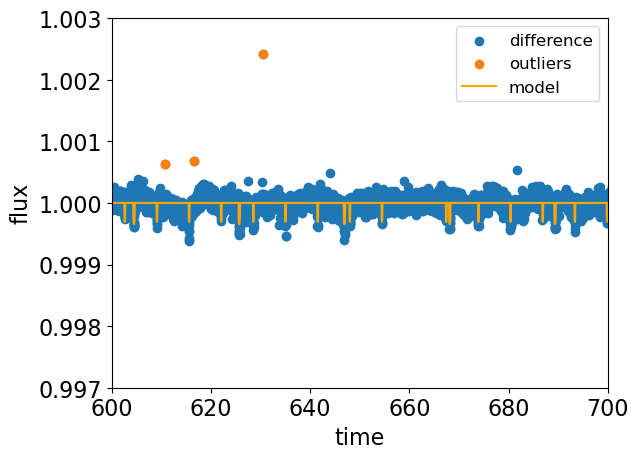

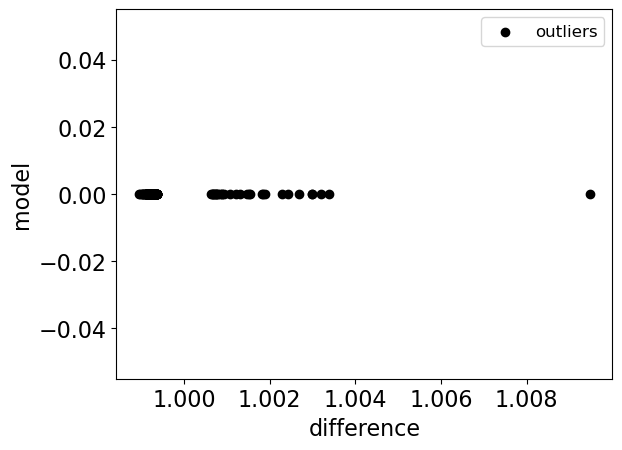

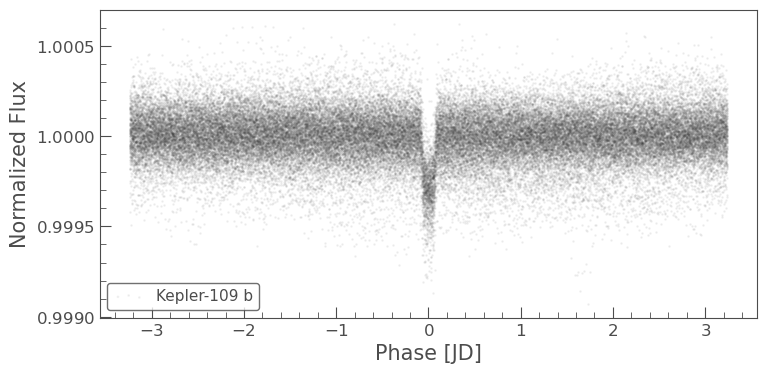

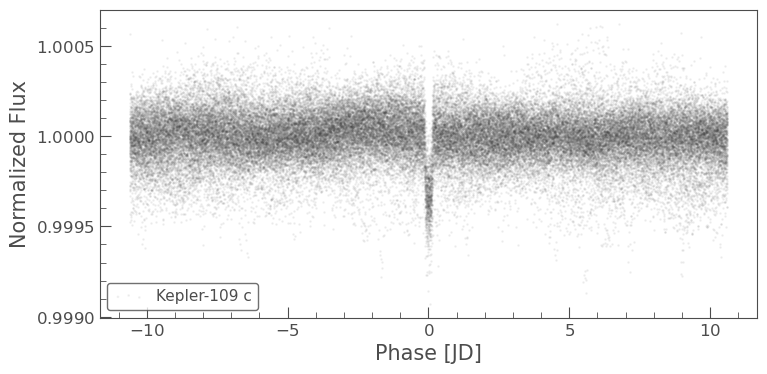

In [8]:
model, difference, std_calculated, mean_tweaked = model_data_residuals(param_lists, lc)
lc_final, flags_nsigma = remove_outliers(5, lc, difference, std_calculated, mean_tweaked) 
diagnostic_plots(lc, lc_final, model, difference, std_calculated, mean_tweaked, sigma=5)

In [9]:
param_lists

{'pl_name': ['Kepler-109 b', 'Kepler-109 c'],
 'pl_letter': ['b', 'c'],
 'pl_orbper': [6.4816307, 21.22265],
 'pl_orbincl': [87.06, 89.63],
 'pl_orbeccen': [0.11, 0.098],
 'pl_trandep': [0.03015, 0.03599],
 'pl_tranmid': [2454955.97791, 2454970.5722],
 'pl_trandur': [3.649, 6.4913],
 'pl_ratror': [0.01686, 0.01734],
 'pl_imppar': [0.58, 0.16],
 'st_rad': [1.39, 1.39],
 'st_mass': [1.09, 1.09],
 'st_dens': [0.65, 0.65],
 'gaia_id': ['Gaia DR2 2101175933393051008', 'Gaia DR2 2101175933393051008'],
 'pl_rade': [2.49, 2.65],
 'berger_dens': [0.5557129614951429, 0.5557129614951429]}

[{'index': 6017,
  'log_power': -22.241724061728746,
  'period': 10.883160170918373,
  'period_uncert': 0.03123232990206864},
 {'index': 4697,
  'log_power': -22.378826301835943,
  'period': 13.528070110219879,
  'period_uncert': 0.04902405706672987},
 {'index': 9218,
  'log_power': -22.53716868754418,
  'period': 7.382635685929924,
  'period_uncert': 0.014679660182279338},
 {'index': 9524,
  'log_power': -22.63582409816445,
  'period': 7.162696406214108,
  'period_uncert': 0.014089279553993818},
 {'index': 10594,
  'log_power': -22.657879921607673,
  'period': 6.485914511696979,
  'period_uncert': 0.012351559371928325}]

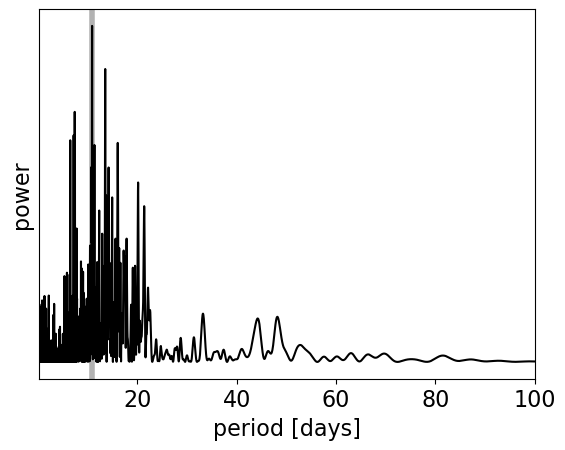

In [10]:
x = lc_final['time'].value 
y = lc_final['flux'].value 

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=5, min_period=0.1, max_period=100.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

results['peaks']

In [11]:
from astropy.timeseries import BoxLeastSquares

x = lc_final['time'].value 
y = lc_final['flux'].value 

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(10):
    bls = BoxLeastSquares(x[~m], y[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Text(5, -5, 'planet e')

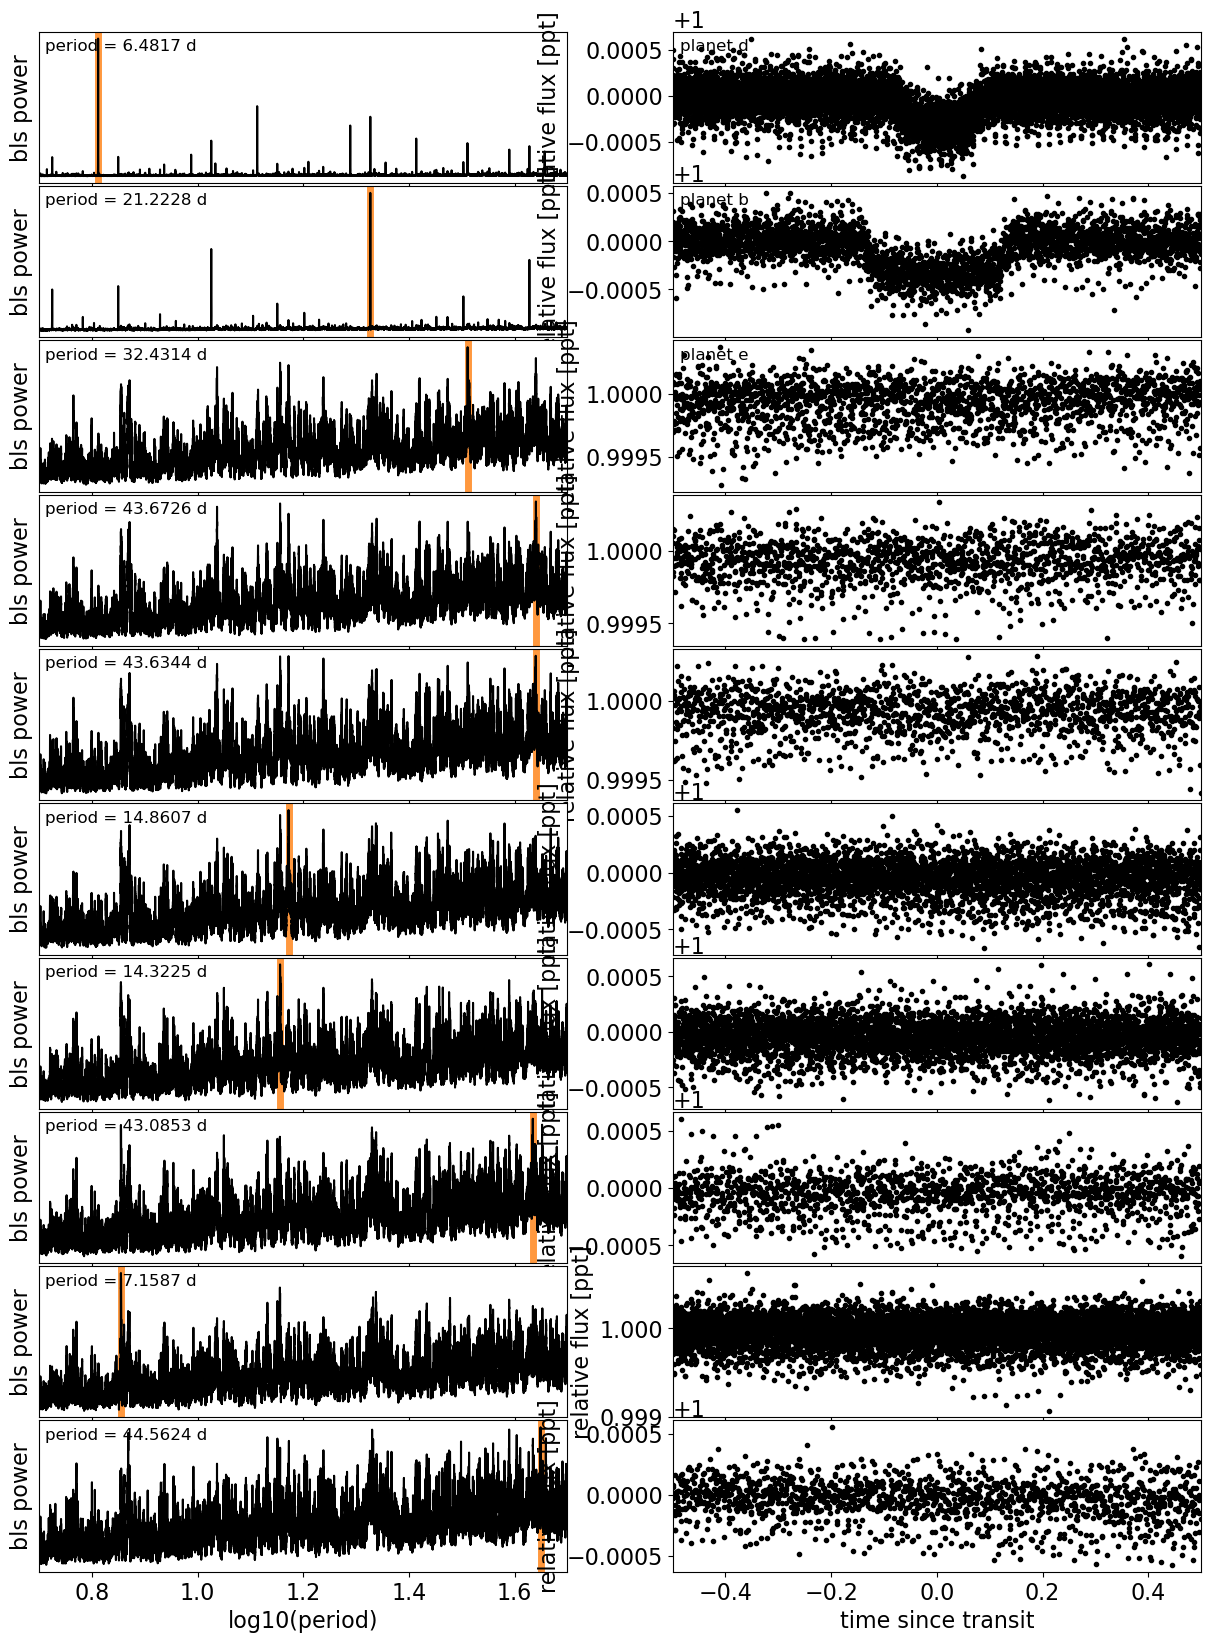

In [12]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 20))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate(
        "period = {0:.4f} d".format(periods[i]),
        (0, 1),
        xycoords="axes fraction",
        xytext=(5, -5),
        textcoords="offset points",
        va="top",
        ha="left",
        fontsize=12,
    )
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.5
    ax.plot(x_fold[m], y[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.51, 0.51, 100)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y)
    denom[num == 0] = 1.0
    #ax.scatter(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

_ = fig.subplots_adjust(hspace=0.02)

axes[0,1].annotate("planet d",(0, 1),xycoords="axes fraction",xytext=(5, -5),textcoords="offset points",va="top",ha="left",fontsize=12)
axes[1,1].annotate("planet b",(0, 1),xycoords="axes fraction",xytext=(5, -5),textcoords="offset points",va="top",ha="left",fontsize=12)
axes[2,1].annotate("planet e",(0, 1),xycoords="axes fraction",xytext=(5, -5),textcoords="offset points",va="top",ha="left",fontsize=12)


In [13]:
def plot_fittedlightcurves(lc_final, map_soln):

    t = lc_final["time"].value
    y = lc_final["flux"].value
    gp_mod = map_soln["gp_pred"] + map_soln["mean"]

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
    
    # plotting gp_model against data 
    ax = axes[0]
    ax.plot(t, y, "k", label="data")
    ax.plot(t, gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux")

    # plotting de-trended data 
    ax = axes[1]
    ax.plot(t, y - gp_mod, "k", label="de-trended data")
    for i, l in enumerate(param_lists['pl_letter']):
        ax.plot(t, map_soln["light_curves"][:, i], label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")
    
    # plotting residuals 
    ax = axes[2]
    mod = gp_mod + np.sum(map_soln["light_curves"], axis=-1)
    rms = np.sqrt(np.median((y-mod)**2))
    mask = np.abs(y-mod) < 7 * rms
    ax.plot(t, y - mod, "k")
    plt.plot(t[~mask], (y-mod)[~mask], "xr", label="outliers")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")


    plt.xlim(400,620)
    plt.xlabel("time [days]")
    plt.tight_layout()

    return fig, mask 

In [14]:
def plot_fitted_folded2(lc_final, map_soln):
        
    for n, letter in enumerate(param_lists['pl_letter']):
        plt.figure()
    
        t = lc_final["time"].value
        y = lc_final["flux"].value
        period = map_soln["period"][n]
        t0 = np.median(map_soln["t0"][n])
    
        gp_mod = map_soln["gp_pred"] + map_soln["mean"]
        
        # Plot the folded data
        x_fold = (t - t0 + 0.5 * period) % period - 0.5 * period
        plt.plot(x_fold, y - gp_mod, ".k", label="data", zorder=-1000)
        
        # Overplot the phase binned light curve
        bins = np.linspace(-0.51, 0.51, 50)
        denom, _ = np.histogram(x_fold, bins)
        num, _ = np.histogram(x_fold, bins, weights=y - map_soln['mean'])
        denom[num == 0] = 1.0
        plt.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned")
        
        # Plot the folded model
        plt.plot(np.sort(x_fold), map_soln["light_curves"][:,n][np.argsort(x_fold)], color="C1", label="model")
        
        plt.legend(fontsize=10, loc=4)
        plt.xlim(-0.5 * period, 0.5 * period)
        plt.xlabel("time since transit [days]")
        plt.ylabel("de-trended flux")
        _ = plt.xlim(-0.5, 0.5)

In [15]:
def folded_plots(lc_final, map_soln):
    detrended_data = lk.LightCurve(time=lc_final['time'], flux=lc_final['flux']-map_soln["gp_pred"])

    for n, letter in enumerate(param_lists['pl_letter']):

        model = lk.LightCurve(time=lc_final['time'], flux=map_soln["light_curves"][:,n]+map_soln['mean'])
    
        fig, ax = plt.subplots(figsize=(12,4))
        lc_final.fold(period=map_soln['period'][n], epoch_time=map_soln['t0'][n]).scatter(ax=ax, alpha=1, label='raw data')
        detrended_data.fold(period=map_soln['period'][n], epoch_time=map_soln['t0'][n]).scatter(ax=ax, label='data $-$ gp model')
        model.fold(period=map_soln['period'][n], epoch_time=map_soln['t0'][n]).plot(ax=ax,color='k',lw=2,label='model')
        plt.xlim(-0.75,0.75)
        plt.legend(fontsize=12, loc='lower right')
        plt.title('planet '+ str(letter))
        plt.annotate("radius = {0:.4f} R$\oplus$".format(map_soln['r_p'][n]*units.solRad.to(units.earthRad)),(0, 0),xycoords="axes fraction",xytext=(7,20),textcoords="offset points",va="top",ha="left",fontsize=12)
    

In [16]:
def optimise_model(lc, initial_guesses, texp=0.5 / 24, u_init=[0.3, 0.2], start=None, use_mass=False, log_density=True, include_depth=True, log_depth=True, complicated_gp=False):
    """Optimise a transit model to fit some data

    Parameters
    ----------
    lc : :class:`~lightkurve.Lightcurve`
        The lightcurve data
    initial_guesses : `dict`
        Dictionary of initial guesses
    texp : `float`, optional
        Exposure time, by default 0.5/24
    u_init : `list`, optional
        Initial limb darkening guesses, by default [0.3, 0.2]

    Returns
    -------
    model
        PyMC3 model
    map_soln : `dict`
        Dictionary of optimised parameters
    """
    n_planets = len(initial_guesses["pl_orbper"])
    t0s_bkjd = Time(initial_guesses["pl_tranmid"], format="jd").bkjd
    mass_star = np.array(initial_guesses['st_mass'])
    depths = np.array(initial_guesses['pl_trandep'])/100

    with pm.Model() as model:

        # The baseline flux
        mean = pm.Normal("mean", mu=1.0, sd=1.0) 

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s_bkjd, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(initial_guesses["pl_orbper"]), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening parameters
        # An uninformative prior for quadratic limb darkening parameters, flat distribution 
        # u1 (scalar) – The first limb darkening coefficient
        # u2 (scalar) – The second limb darkening coefficient
        u = xo.distributions.QuadLimbDark("u", testval=u_init)
        model_lightcurve = xo.LimbDarkLightCurve(u[0], u[1])
        
        # stellar density 
        initial_dens = initial_guesses["st_dens"][0] if initial_guesses["berger_dens"][0] == -1.0\
            else initial_guesses["berger_dens"][0]
        
        if log_density == True:
            log_rho_star = pm.Normal("log_rho_star",mu=np.log(initial_dens), sd=1)
            rho_star = pm.Deterministic("rho_star", tt.exp(log_rho_star))
            
            system_vars = [log_rho_star]
            
        else: 
            rho_star = pm.Normal("rho_star",mu=initial_dens, sd=1)
            
            system_vars = [rho_star]
        
        # calculating the stellar radius from density and mass 
        if use_mass == True: 
            r_star = pm.Deterministic("r_star", (((mass_star/rho_star)/((4/3)*np.pi))**(1/3)) * ((units.solMass / (units.g/units.cm**3))**(1/3)).to(units.solRad))
        
        else: 
            r_star = pm.Normal("r_star", mu=initial_guesses["st_rad"][0], sd=10.0)
            
        if include_depth == True:
            
            if log_depth == True: 
                log_depth = pm.Normal("log_depth", mu=np.log(depths), sd=1.0, shape=n_planets)
                depth = pm.Deterministic("depth", tt.exp(log_depth))
                
                system_vars.append(log_depth)
                
            else: 
                depth = pm.Normal("depth", mu=depths, sd=2.0, shape=n_planets)
                
                system_vars.append(depth)
            
            b = pm.Uniform("b", lower=0, upper=1, shape=n_planets, testval=initial_guesses["pl_imppar"])
        
            ror = pm.Deterministic("ror", model_lightcurve.get_ror_from_approx_transit_depth(depth, b))
            
            system_vars.extend([b, t0, mean, logP, r_star, ror, u])
            
        else:
            # the radius ratio between the planet and star 
            ror = pm.Uniform("ror", lower=0.001, upper=0.1, shape=n_planets, testval=initial_guesses["pl_ratror"])
        
            # the impact parameter, uniformly distributed between 0 and 1+ror, where ror is the radius ratio between planet and star
            b = xo.distributions.ImpactParameter("b", ror=ror, shape=n_planets, testval=initial_guesses["pl_imppar"]) 
            
            system_vars.extend([b, t0, mean, logP, r_star, ror, u])
        
        # the radius of the orbiting body, in units of solar radii 
        r_p = pm.Deterministic('r_p', ror*r_star)
        system_vars.append(r_p)

        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)

        # Compute the model light curve using starry
        light_curves = model_lightcurve.get_light_curve(
            orbit=orbit, r=r_p, t=lc["time"].value, texp=texp) # check texp 
        light_curve = tt.sum(light_curves, axis=-1) + mean 

        # Here we track the value of the model light curve for plotting purposes
        pm.Deterministic("light_curves", light_curves) # typo? 
        
        # Gaussian process 
        if complicated_gp == True: 
            log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(lc['flux_err'])), sd=1)
            sigma_rot = pm.InverseGamma("sigma_rot", **pmx.estimate_inverse_gamma_parameters(1, 5))
            log_prot = pm.Normal("log_prot", mu=np.log(peak['period']), sd=0.02)
            prot = pm.Deterministic("prot", tt.exp(log_prot))
            log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
            log_dQ = pm.Normal("log_dQ", mu=0, sd=2)
            f = pm.Uniform("f", lower=0.01, upper=1)
            
            kernel = terms.RotationTerm(sigma=sigma_rot,period=prot,
                                        Q0=tt.exp(log_Q0),dQ=tt.exp(log_dQ),f=f)
            
            gaussian_vars = [log_jitter, sigma_rot, log_prot, log_Q0, log_dQ, f]
    
        else: 
            # A jitter term describing excess white noise
            log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(lc['flux_err'])), sd=2)
    
            # The standard deviation of the process
            # defined as sqrt(S0 * w0 * Q)
            # where S0 is related to the power when w = 0 
            # and w0 is the undamped angular frequency
            log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.mean(lc['flux_err'])), sd=10)
        
            # the undamped period of the oscillator
            # 2pi / w0 
            log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10) # in days, constrain a little bit 
        
            log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
    
            # GP model for the light curve
            kernel = terms.SHOTerm(sigma=tt.exp(log_sigma_gp),
                               rho=tt.exp(log_rho_gp),
                               Q=tt.exp(log_Q0))
            
            gaussian_vars = [log_jitter, log_sigma_gp, log_rho_gp, log_Q0]
    
        gp = GaussianProcess(kernel, 
                             t=lc['time'].value, 
                             diag=lc['flux_err'].value**2 + tt.exp(2*log_jitter), 
                             quiet=True)
        gp.marginal("transit_obs", observed=lc['flux'].value - light_curve)
        pm.Deterministic("gp_pred", gp.predict(lc['flux'].value - light_curve))
        freq = np.linspace(0.01,10,5000)
        pm.Deterministic("psd", kernel.get_psd(freq))
        
        # Optimize the MAP solution
        
        #map_soln = pmx.optimize(start=model.test_point)
    
        if start is None:
            start = model.test_point

        map_soln = start

        map_soln = pmx.optimize(start=map_soln, vars=gaussian_vars[:len(gaussian_vars)//2]) 
        map_soln = pmx.optimize(start=map_soln, vars=gaussian_vars[len(gaussian_vars)//2:]) 
        map_soln = pmx.optimize(start=map_soln, vars=gaussian_vars) 
        map_soln = pmx.optimize(start=map_soln, vars=system_vars[:len(system_vars)//2]) 
        map_soln = pmx.optimize(start=map_soln, vars=system_vars[len(system_vars)//2:]) 
        map_soln = map_soln = pmx.optimize(start=map_soln, vars=[r_p])
        map_soln = pmx.optimize(start=map_soln)
    
    _, mask = plot_fittedlightcurves(lc, map_soln)
    folded_plots(lc, map_soln)
    
    return map_soln, model, mask 

In [17]:
# doesnt get stuck in infinity if i do log_depth, making that automatic

optimizing logp for variables: [log_sigma_gp, log_jitter]


message: Desired error not necessarily achieved due to precision loss.
logp: 512674.7178049018 -> 515385.187498931
optimizing logp for variables: [log_Q0, log_rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 515385.187498931 -> 519285.8005164719
optimizing logp for variables: [log_Q0, log_rho_gp, log_sigma_gp, log_jitter]


message: Optimization terminated successfully.
logp: 519285.8005164719 -> 519337.5859817873
optimizing logp for variables: [mean, t0, b, log_depth, rho_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 519337.5859817873 -> 519543.3513272467
optimizing logp for variables: [log_depth, u, b, r_star, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 519543.3513272467 -> 519545.3726432832
optimizing logp for variables: [log_depth, u, b, r_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 519545.3726432832 -> 519545.3726432834
optimizing logp for variables: [log_Q0, log_rho_gp, log_sigma_gp, log_jitter, b, log_depth, r_star, rho_star, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 519545.3726432834 -> 519547.2963438503


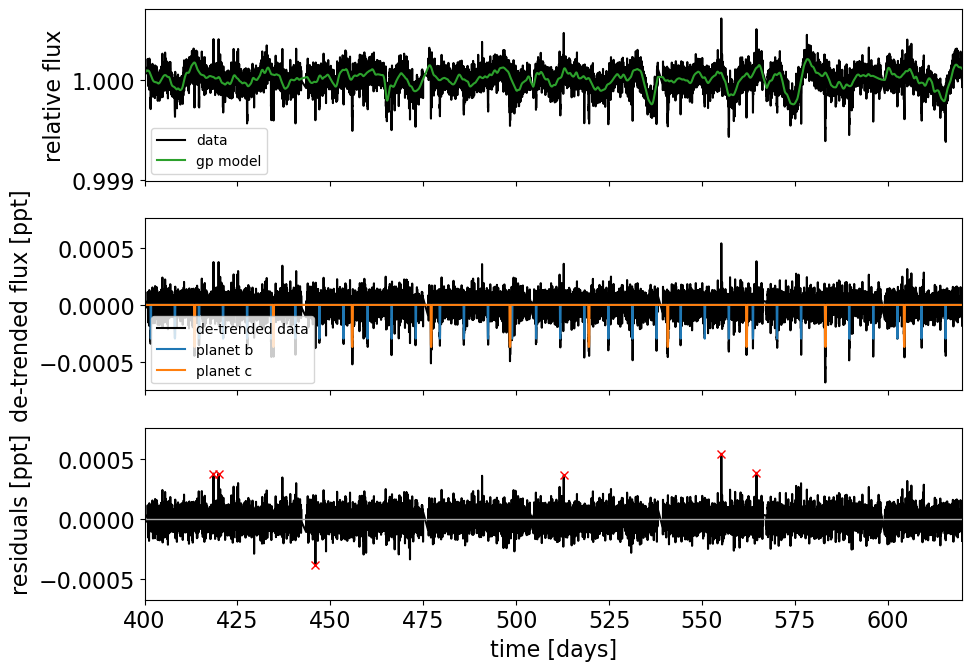

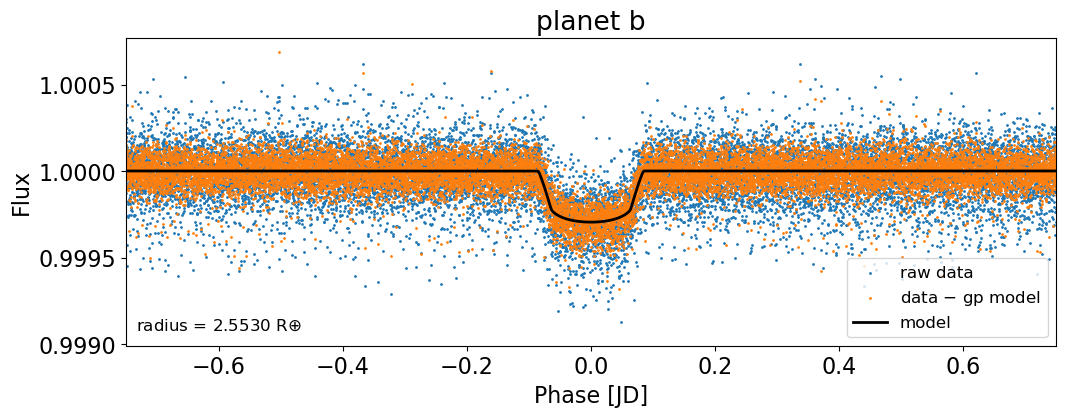

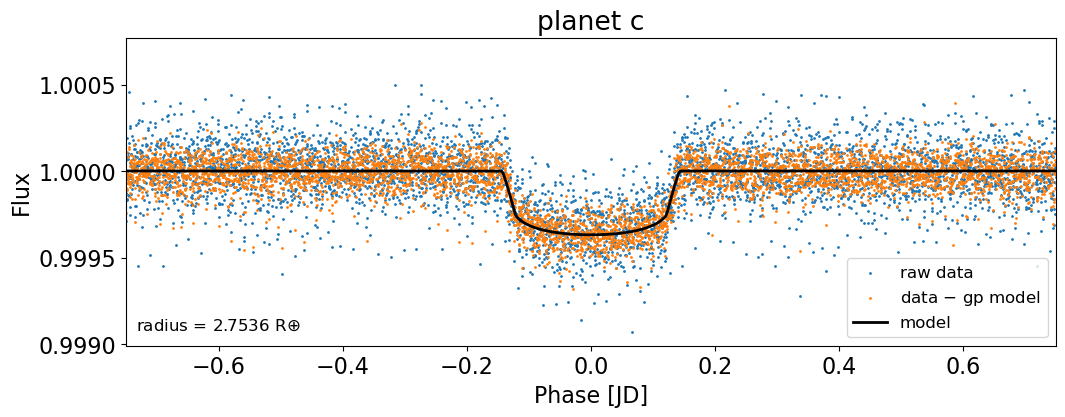

In [18]:
map_soln, model, mask = optimise_model(lc_final, param_lists, use_mass=False, log_density=False, include_depth=True, complicated_gp=False)


In [19]:
map_soln['r_p']*units.solRad.to(units.earthRad)

array([2.55299739, 2.75358095])

In [20]:
param_lists['pl_rade']

[2.49, 2.65]

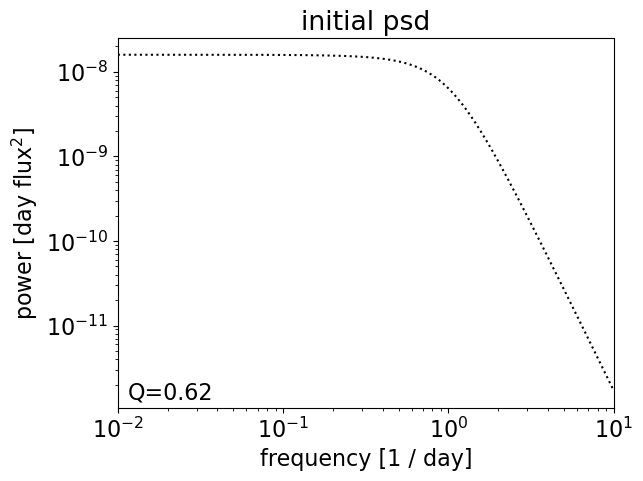

In [21]:
def plot_psd(map_soln):
    fig, ax = plt.subplots()
    plt.title("initial psd")
    plt.text(.02, .01, 'Q={0}'.format(np.round(np.exp(map_soln['log_Q0']),decimals=2)), ha='left', va='bottom', transform=ax.transAxes)
    freq = np.linspace(0.01,10,5000)
    plt.loglog(freq, map_soln['psd'], ":k", label="full model")
    plt.xlim(freq.min(), freq.max())
    plt.xlabel("frequency [1 / day]")
    plt.ylabel("power [day flux$^2$]")
plot_psd(map_soln)

In [22]:
def plot_fitted_folded0(lc_final, map_soln):

    for n, letter in enumerate(param_lists['pl_letter']):
        plt.figure()
    
        x = lc_final["time"].value
        y = lc_final["flux"].value
        period = map_soln["period"][n]
        t0 = np.median(map_soln["t0"][n])
    
        x_fold = (x - t0 + 0.5 * period) % period - 0.5 * period
        m = np.abs(x_fold) < 0.5
        plt.scatter(x_fold,1e3 * (y - map_soln["gp_pred"]),c="k",marker=".",alpha=0.5,linewidths=0,)

        lc_mod = map_soln["light_curves"][:,n]
        lc_modx = np.sort(x_fold)
        lc_mody = lc_mod[np.argsort(x_fold)]
        plt.plot(lc_modx, 1e3 * (lc_mody + map_soln["mean"]), c="purple", zorder=1)

        # Overplot the phase binned light curve
        bins = np.linspace(-0.51, 0.51, 100)
        denom, _ = np.histogram(x_fold, bins)
        num, _ = np.histogram(x_fold, bins, weights=y - map_soln["gp_pred"])
        denom[num == 0] = 1.0
        plt.plot(0.5 * (bins[1:] + bins[:-1]),1e3 * num / denom,color="C1",zorder=2)

        plt.xlim(-0.5, 0.5)
        #plt.ylim(-3, 0.5)
        plt.ylabel("de-trended flux [ppt]")
        _ = plt.xlabel("time since transit")
    
        plt.title("planet {0}".format(letter))
        
#_ = plot_fitted_folded0(lc_final, map_soln)

In [23]:
def plot_fitted_folded1(lc_final, map_soln):

    for n, letter in enumerate(param_lists['pl_letter']):
        plt.figure()
    
        x = lc_final["time"].value
        y = lc_final["flux"].value
        period = map_soln["period"][n]
        t0 = np.median(map_soln["t0"][n])

        x_fold = (x - t0 + 0.5 * period) % period - 0.5 * period
        m = np.abs(x_fold) < 0.5
        plt.scatter(x_fold[m],1e3 * (y[m] - map_soln["gp_pred"][m]),c="k",marker=".",alpha=0.2,linewidths=0,)

        lc_mod = map_soln["light_curves"][:,n]
        lc_modx = np.sort(x_fold)
        lc_mody = lc_mod[np.argsort(x_fold)]
        plt.plot(lc_modx, 1e3 * (lc_mody + map_soln["mean"]), c="purple", zorder=1)

        # Overplot the phase binned light curve
        bins = np.linspace(-0.51, 0.51, 100)
        denom, _ = np.histogram(x_fold, bins)
        num, _ = np.histogram(x_fold, bins, weights=y - map_soln["gp_pred"])
        denom[num == 0] = 1.0
        plt.scatter(0.5 * (bins[1:] + bins[:-1]),1e3 * num / denom,color="C1",zorder=2,linewidths=0,)

        plt.xlim(-0.5, 0.5)
        #plt.ylim(-3, 0.5)
        plt.ylabel("de-trended flux [ppt]")
        _ = plt.xlabel("time since transit")
#plot_fitted_folded1(lc_final, map_soln)

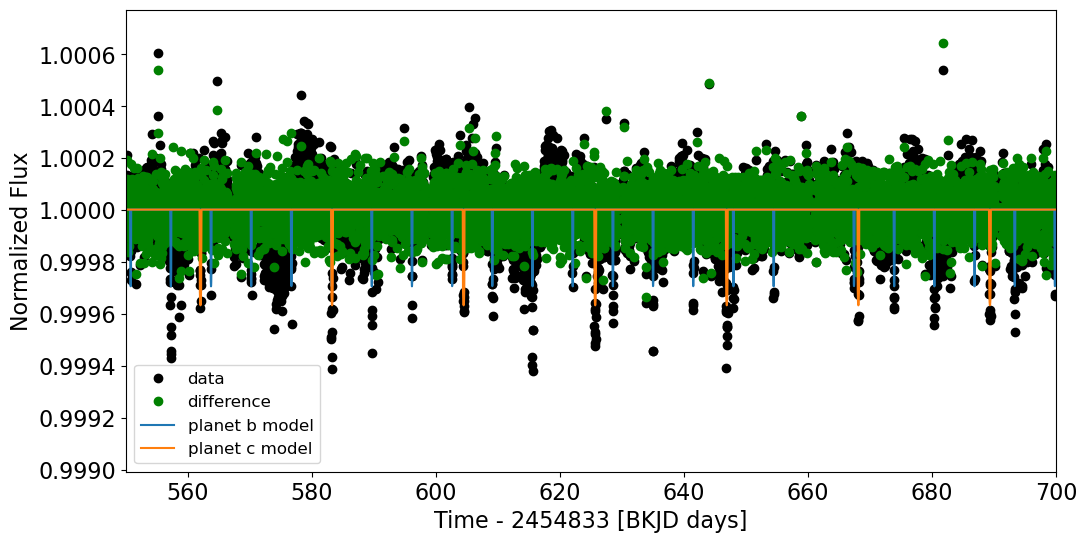

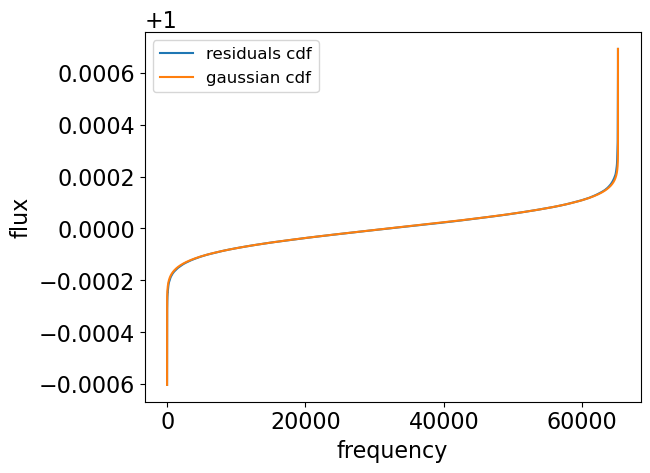

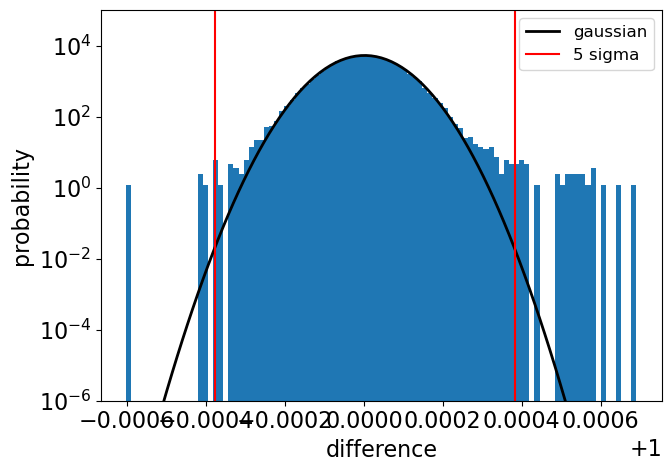

In [24]:
def diagnostic_plots_refined(lc_final, map_soln):
    t = lc_final["time"].value
    y = lc_final["flux"].value
    gp_mod = map_soln["gp_pred"]
    model = np.sum(map_soln["light_curves"], axis=-1)
    detrended_flux = y - gp_mod
    difference = detrended_flux - model 
    
    p = lc.scatter()
    plt.close()
    fig, ax = plt.subplots(figsize=(12,6))
    plt.plot(t,y,color='k',marker='o',ls='',label='data')
    plt.plot(t,difference,marker='o',ls='',color='green',label='difference')
    for i, l in enumerate(param_lists['pl_letter']):
        plt.plot(t, map_soln["light_curves"][:, i]+map_soln['mean'], label="planet {0} model".format(l))
    plt.xlabel(p.get_xlabel())
    plt.ylabel(p.get_ylabel())
    plt.xlim(550,700)
    #plt.ylim(0.998, 1.001)
    plt.legend(loc='lower left', fontsize=12)
    plt.show()

    diff_sorted = np.sort(difference)
    N = len(diff_sorted)
    p = np.arange(N)
    f = lambda x: np.interp(x, p, diff_sorted)
    one_sigma_pos = f((0.8413)*N)
    one_sigma_neg = f((1-0.8413)*N)
    std_calculated = (one_sigma_pos - one_sigma_neg)/2
    
    norm_cdf = norm.cdf((diff_sorted - map_soln['mean'])/std_calculated)

    plt.plot(p, diff_sorted,label='residuals cdf')
    plt.plot(norm_cdf*N, diff_sorted, label='gaussian cdf')
    #plt.ylim(0.9995,1.0005)
    plt.xlabel("frequency")
    plt.ylabel("flux")
    plt.legend(fontsize=12)
    plt.show()
    
    sigma=5
    
    fig, ax = plt.subplots(figsize=(7,5))
    h, bins = np.histogram(difference, bins=100)
    plt.hist(difference, bins=bins, density=True)
    plt.plot(bins, norm(map_soln['mean'], std_calculated).pdf(bins), linewidth=2, color='black',label='gaussian')
    plt.axvline(map_soln['mean']-(sigma*std_calculated),color='red')
    plt.axvline(map_soln['mean']+(sigma*std_calculated),color='red',label="{0} sigma".format(sigma))
    plt.ylim(1e-6,1e5)
    #plt.xlim(0.999,1.001)
    plt.yscale('log')
    plt.xlabel("difference")
    plt.ylabel("probability")
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
diagnostic_plots_refined(lc_final, map_soln)

In [25]:
new_guesses = param_lists.copy()
new_guesses['pl_orbper'] = map_soln['period'].tolist()
new_guesses['pl_trandep'] = map_soln['depth'].tolist()
new_guesses['pl_ratror'] = map_soln['ror'].tolist()
new_guesses['pl_imppar'] = map_soln['b'].tolist()
new_guesses['st_rad'] = [map_soln['r_star'].tolist()]
new_guesses['berger_dens'] = [map_soln['rho_star'].tolist()]
#new_guesses['pl_tranmid'] = # make this more efficient later 

optimizing logp for variables: [log_sigma_gp, log_jitter]


message: Optimization terminated successfully.
logp: 512840.9623760218 -> 515790.396960495
optimizing logp for variables: [log_Q0, log_rho_gp]


message: Optimization terminated successfully.
logp: 515790.396960495 -> 519731.6179876526
optimizing logp for variables: [log_Q0, log_rho_gp, log_sigma_gp, log_jitter]


message: Desired error not necessarily achieved due to precision loss.
logp: 519731.6179876526 -> 519784.6133758629
optimizing logp for variables: [mean, t0, b, log_depth, rho_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 519784.6133758629 -> 519997.73773450777
optimizing logp for variables: [log_depth, u, b, r_star, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 519997.73773450777 -> 519999.74587810814
optimizing logp for variables: [log_depth, u, b, r_star]


message: Optimization terminated successfully.
logp: 519999.74587810814 -> 519999.74587810814
optimizing logp for variables: [log_Q0, log_rho_gp, log_sigma_gp, log_jitter, b, log_depth, r_star, rho_star, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 519999.74587810814 -> 520001.7774216704


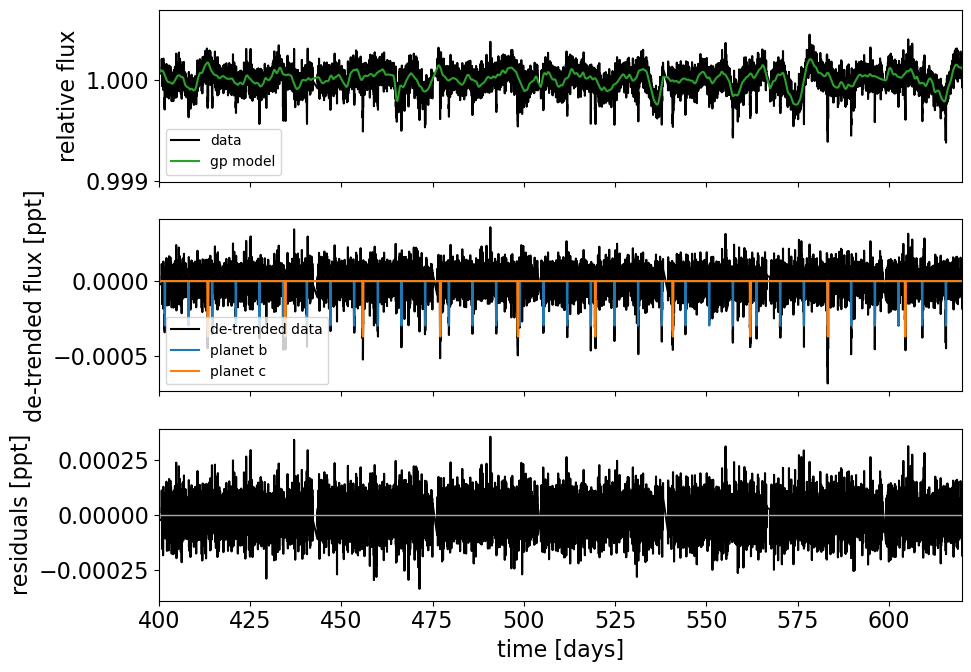

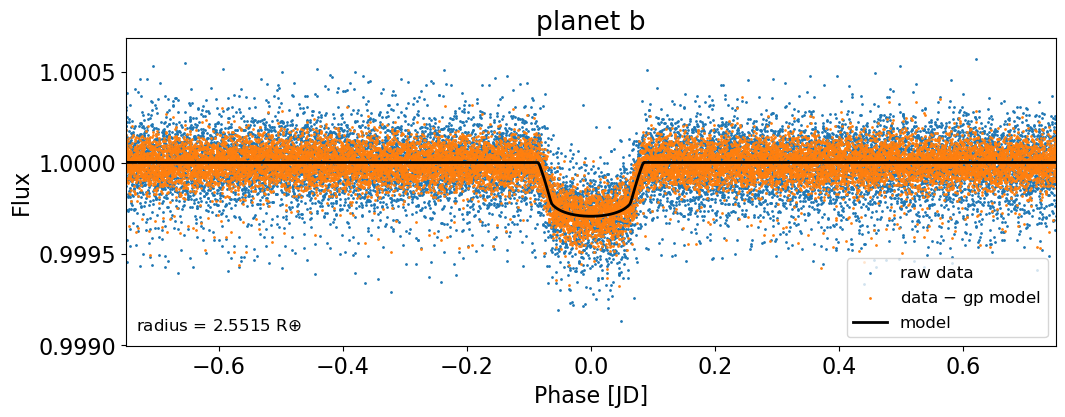

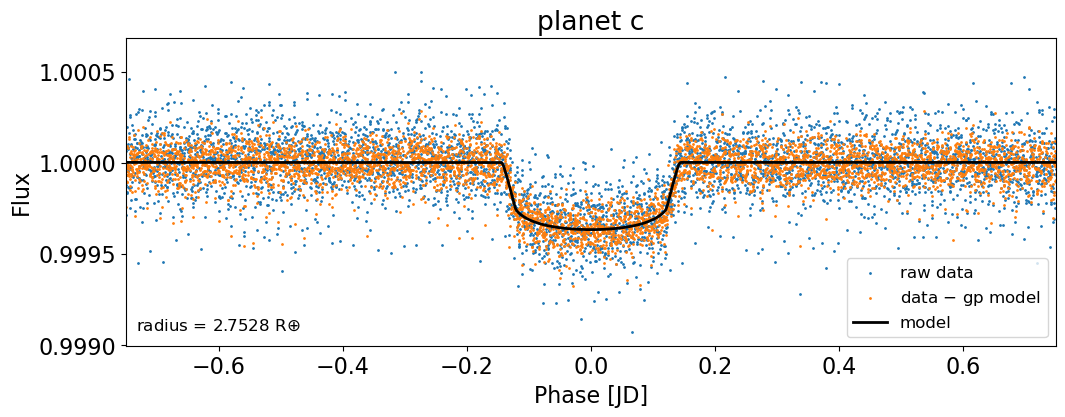

In [26]:
updated_map_soln, updated_model, updated_mask = optimise_model(lc_final[mask], param_lists, use_mass=False, log_density=False, include_depth=True, complicated_gp=False)


In [27]:
updated_map_soln['r_p']*units.solRad.to(units.earthRad)

array([2.5515432 , 2.75281742])

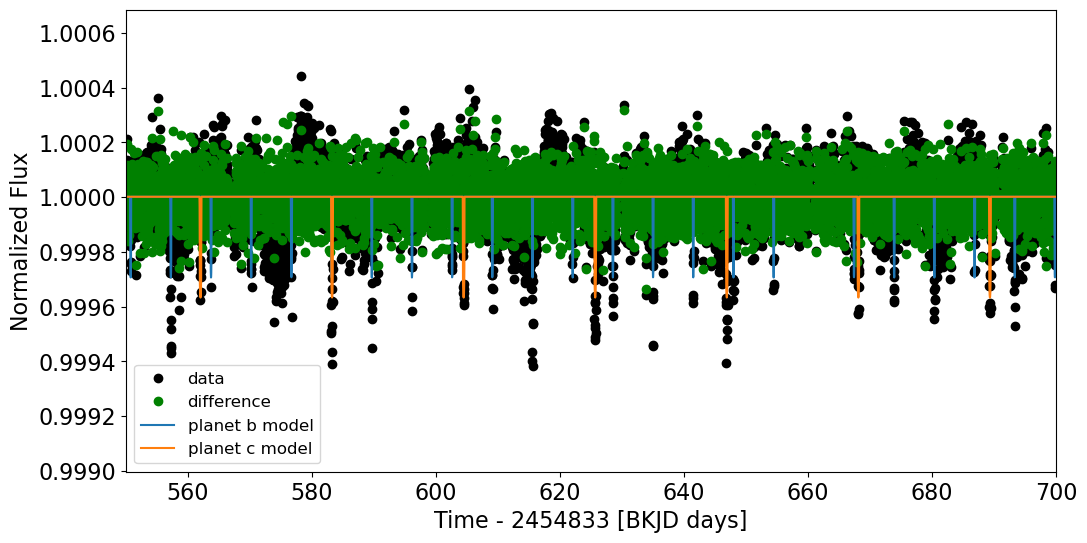

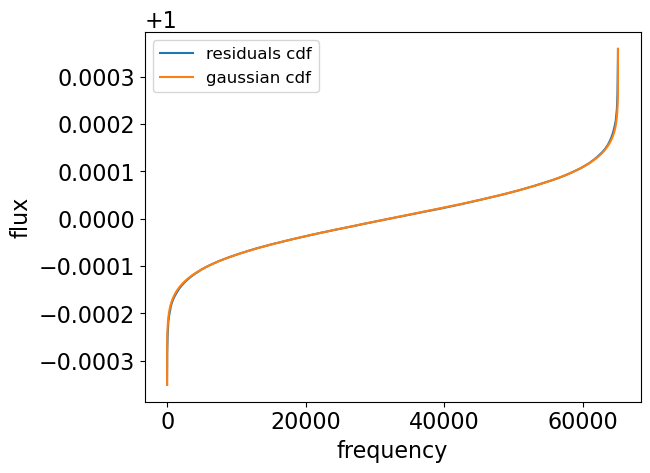

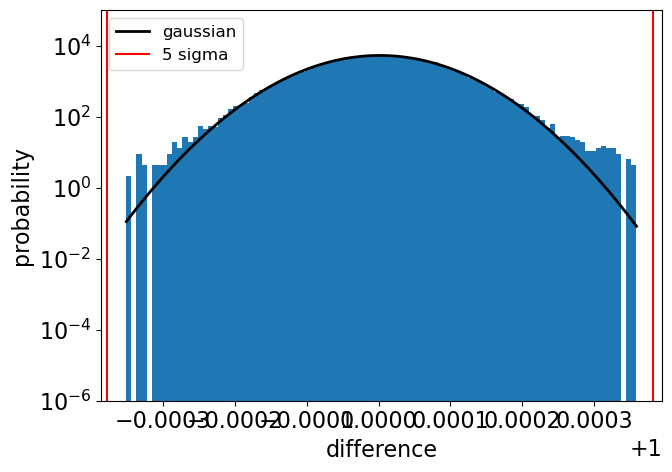

In [28]:
diagnostic_plots_refined(lc_final[mask], updated_map_soln)